## Distorted Long-Memory Model
$$
y_t = x^2_{t-1}~x_t
$$

$$
x_t = .99 x_{t-1} + \epsilon_t, \epsilon \sim N(0, \sigma^2)
$$


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import plt

In [2]:
np.random.seed(123)

In [3]:
def rng(time_steps, scale):
    rn = np.random.normal(0., scale, (time_steps, 1))
    rn -= rn.mean()
    return rn

In [4]:
def dlm_model(time_steps=500, x0=.5, sigma=.5):
    eps = rng(time_steps, scale=sigma)
    x = np.zeros(time_steps)
    x[0] = x0
    y = x
    
    for i in range(1, time_steps):
        x[i] = .99*x[i-1] + eps[i]
    
    y[1:] = x[:-1]**2 * x[1:]
    return y

In [5]:
y = dlm_model(time_steps=500)

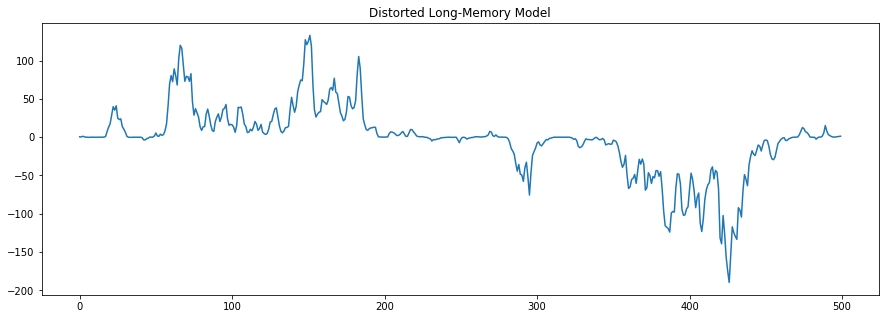

In [6]:
plt.figure(figsize=(15,5))
plt.title('Distorted Long-Memory Model')
plt.plot(y);
#plt.plot(np.log(y[1:]/y[:-1]));

In [7]:
df = pd.DataFrame(y, columns=['dlm_model'], index=range(500))

In [8]:
lags = 4
cols = []
for lag in range(1,lags+1):
    col = 'lag_%d'% lag
    cols.append(col)
    df[col] = df['dlm_model'].shift(lag)

df = df.dropna(how='any')

In [9]:
Y = df[['dlm_model']].values
X = df[cols].values

test_Y = Y[-100:]
test_X = X[-100:]

train_Y = Y[:-100]
train_X = X[:-100]

## OLS Regression

In [10]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

/home/mehdi/Py36Env/py36env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
model = sm.OLS(train_Y, train_X)
results = model.fit()
#results.summary()

In [12]:
ols_results = pd.DataFrame(y, columns=['model'])
ols_results['in_sample'] = np.nan
ols_results['out_sample'] = np.nan

ols_in_sample = results.fittedvalues.flatten()
ols_out_sample = results.predict(test_X)

ols_results.loc[5:400, 'in_sample'] = results.fittedvalues.flatten()
ols_results.loc[400:, 'out_sample'] = results.predict(test_X)

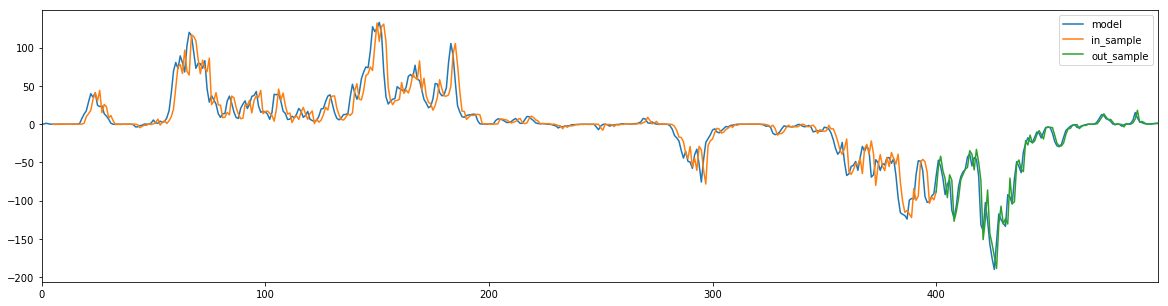

In [13]:
ols_results.plot(figsize=(20, 5));

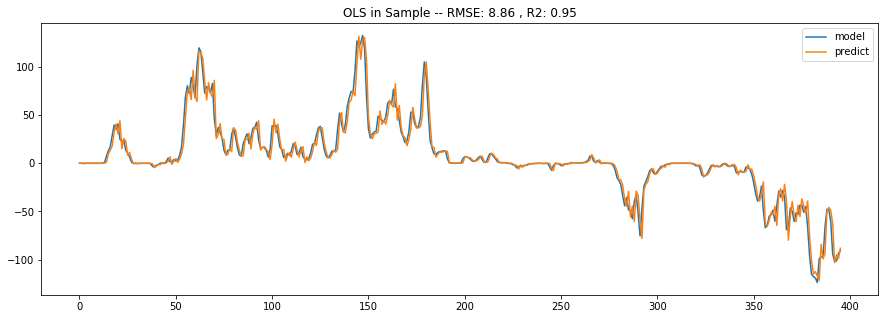

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(ols_in_sample, label='predict')
# calculate root mean squared error
ols_train_rmse = np.sqrt(mean_squared_error(train_Y.flatten(), ols_in_sample))
plt.title('OLS in Sample -- RMSE: %.2f , R2: %.2f' % (ols_train_rmse, r2_score(train_Y.flatten(), ols_in_sample)))
plt.legend(loc=0)
plt.show()

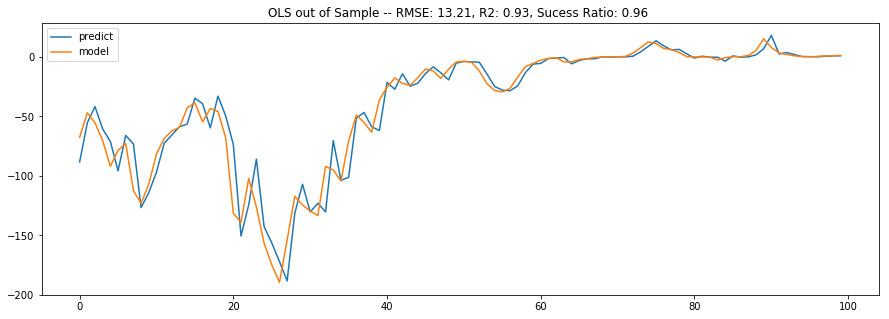

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(ols_out_sample, label='predict')
plt.plot(test_Y, label='model')
# calculate root mean squared error
ols_test_rmse = np.sqrt(mean_squared_error(test_Y.flatten(), ols_out_sample))
# Success ratio
sr = np.mean(np.sign(ols_out_sample)==np.sign(test_Y.flatten()))

plt.title('OLS out of Sample -- RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (ols_test_rmse, r2_score(test_Y.flatten(), ols_out_sample), sr))
plt.legend(loc=0)
plt.show()

## Deep Learning with Keras

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.advanced_activations import *
import keras.backend as Kb

Using Theano backend.


In [17]:
def success_ratio(y_true, y_pred):
    return Kb.mean(Kb.equal(Kb.sign(y_true), Kb.sign(y_pred)))

In [18]:
def r_coeff(y_true, y_pred):
    rss = Kb.sum(Kb.square(y_true-y_pred))
    sst = Kb.sum(Kb.square(y_true-Kb.mean(y_true)))
    return 1-(rss/(sst+Kb.epsilon()))

In [77]:
model = Sequential()
model.add(Dense(3, input_dim=lags))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=[success_ratio, r_coeff])

In [78]:
history = model.fit(train_X, train_Y, 
                    epochs=5000, 
                    batch_size=len(train_X),
                    verbose=2,
                    validation_data=(test_X, test_Y),
                    shuffle=False, 
                   )

Train on 396 samples, validate on 100 samples
Epoch 1/5000
0s - loss: 736.0932 - success_ratio: 0.7828 - r_coeff: 0.5207 - val_loss: 1338.6542 - val_success_ratio: 0.7600 - val_r_coeff: 0.4643
Epoch 2/5000
0s - loss: 721.4927 - success_ratio: 0.7904 - r_coeff: 0.5302 - val_loss: 1322.0118 - val_success_ratio: 0.7600 - val_r_coeff: 0.4710
Epoch 3/5000
0s - loss: 711.2451 - success_ratio: 0.7929 - r_coeff: 0.5369 - val_loss: 1308.3868 - val_success_ratio: 0.7600 - val_r_coeff: 0.4764
Epoch 4/5000
0s - loss: 702.8485 - success_ratio: 0.7980 - r_coeff: 0.5424 - val_loss: 1296.5144 - val_success_ratio: 0.7600 - val_r_coeff: 0.4812
Epoch 5/5000
0s - loss: 695.5261 - success_ratio: 0.8005 - r_coeff: 0.5471 - val_loss: 1285.8103 - val_success_ratio: 0.7600 - val_r_coeff: 0.4855
Epoch 6/5000
0s - loss: 688.9194 - success_ratio: 0.8030 - r_coeff: 0.5514 - val_loss: 1275.9504 - val_success_ratio: 0.7600 - val_r_coeff: 0.4894
Epoch 7/5000
0s - loss: 682.8292 - success_ratio: 0.8030 - r_coeff: 0.55

0s - loss: 301.3727 - success_ratio: 0.8914 - r_coeff: 0.8038 - val_loss: 630.7410 - val_success_ratio: 0.9100 - val_r_coeff: 0.7476
Epoch 168/5000
0s - loss: 299.9986 - success_ratio: 0.8939 - r_coeff: 0.8047 - val_loss: 628.4219 - val_success_ratio: 0.9100 - val_r_coeff: 0.7485
Epoch 169/5000
0s - loss: 298.6307 - success_ratio: 0.8939 - r_coeff: 0.8056 - val_loss: 624.8421 - val_success_ratio: 0.9200 - val_r_coeff: 0.7500
Epoch 170/5000
0s - loss: 297.2668 - success_ratio: 0.8939 - r_coeff: 0.8064 - val_loss: 622.5114 - val_success_ratio: 0.9200 - val_r_coeff: 0.7509
Epoch 171/5000
0s - loss: 295.9091 - success_ratio: 0.8939 - r_coeff: 0.8073 - val_loss: 619.0027 - val_success_ratio: 0.9200 - val_r_coeff: 0.7523
Epoch 172/5000
0s - loss: 294.5555 - success_ratio: 0.8939 - r_coeff: 0.8082 - val_loss: 616.6360 - val_success_ratio: 0.9200 - val_r_coeff: 0.7533
Epoch 173/5000
0s - loss: 293.2080 - success_ratio: 0.8939 - r_coeff: 0.8091 - val_loss: 613.2003 - val_success_ratio: 0.9200 -

0s - loss: 133.7761 - success_ratio: 0.9192 - r_coeff: 0.9129 - val_loss: 283.2078 - val_success_ratio: 0.9500 - val_r_coeff: 0.8867
Epoch 347/5000
0s - loss: 133.2411 - success_ratio: 0.9192 - r_coeff: 0.9132 - val_loss: 281.7304 - val_success_ratio: 0.9500 - val_r_coeff: 0.8873
Epoch 348/5000
0s - loss: 132.7079 - success_ratio: 0.9192 - r_coeff: 0.9136 - val_loss: 281.1300 - val_success_ratio: 0.9500 - val_r_coeff: 0.8875
Epoch 349/5000
0s - loss: 132.1800 - success_ratio: 0.9167 - r_coeff: 0.9139 - val_loss: 279.6605 - val_success_ratio: 0.9500 - val_r_coeff: 0.8881
Epoch 350/5000
0s - loss: 131.6539 - success_ratio: 0.9217 - r_coeff: 0.9143 - val_loss: 279.0713 - val_success_ratio: 0.9500 - val_r_coeff: 0.8883
Epoch 351/5000
0s - loss: 131.1328 - success_ratio: 0.9192 - r_coeff: 0.9146 - val_loss: 277.6079 - val_success_ratio: 0.9500 - val_r_coeff: 0.8889
Epoch 352/5000
0s - loss: 130.6134 - success_ratio: 0.9217 - r_coeff: 0.9150 - val_loss: 277.0290 - val_success_ratio: 0.9500 -

0s - loss: 84.9240 - success_ratio: 0.9495 - r_coeff: 0.9447 - val_loss: 197.8098 - val_success_ratio: 0.9500 - val_r_coeff: 0.9208
Epoch 531/5000
0s - loss: 84.8582 - success_ratio: 0.9495 - r_coeff: 0.9447 - val_loss: 197.5478 - val_success_ratio: 0.9500 - val_r_coeff: 0.9210
Epoch 532/5000
0s - loss: 84.7918 - success_ratio: 0.9495 - r_coeff: 0.9448 - val_loss: 197.5729 - val_success_ratio: 0.9500 - val_r_coeff: 0.9209
Epoch 533/5000
0s - loss: 84.7276 - success_ratio: 0.9495 - r_coeff: 0.9448 - val_loss: 197.3191 - val_success_ratio: 0.9500 - val_r_coeff: 0.9210
Epoch 534/5000
0s - loss: 84.6630 - success_ratio: 0.9495 - r_coeff: 0.9449 - val_loss: 197.3391 - val_success_ratio: 0.9500 - val_r_coeff: 0.9210
Epoch 535/5000
0s - loss: 84.6006 - success_ratio: 0.9495 - r_coeff: 0.9449 - val_loss: 197.0933 - val_success_ratio: 0.9400 - val_r_coeff: 0.9211
Epoch 536/5000
0s - loss: 84.5376 - success_ratio: 0.9495 - r_coeff: 0.9450 - val_loss: 197.1082 - val_success_ratio: 0.9400 - val_r_

0s - loss: 79.7385 - success_ratio: 0.9444 - r_coeff: 0.9481 - val_loss: 183.7990 - val_success_ratio: 0.9500 - val_r_coeff: 0.9265
Epoch 721/5000
0s - loss: 79.7286 - success_ratio: 0.9419 - r_coeff: 0.9481 - val_loss: 183.7442 - val_success_ratio: 0.9500 - val_r_coeff: 0.9265
Epoch 722/5000
0s - loss: 79.7191 - success_ratio: 0.9444 - r_coeff: 0.9481 - val_loss: 183.7056 - val_success_ratio: 0.9500 - val_r_coeff: 0.9265
Epoch 723/5000
0s - loss: 79.7094 - success_ratio: 0.9419 - r_coeff: 0.9481 - val_loss: 183.6500 - val_success_ratio: 0.9500 - val_r_coeff: 0.9265
Epoch 724/5000
0s - loss: 79.7001 - success_ratio: 0.9444 - r_coeff: 0.9481 - val_loss: 183.6133 - val_success_ratio: 0.9500 - val_r_coeff: 0.9265
Epoch 725/5000
0s - loss: 79.6906 - success_ratio: 0.9419 - r_coeff: 0.9481 - val_loss: 183.5566 - val_success_ratio: 0.9500 - val_r_coeff: 0.9265
Epoch 726/5000
0s - loss: 79.6814 - success_ratio: 0.9470 - r_coeff: 0.9481 - val_loss: 183.5218 - val_success_ratio: 0.9500 - val_r_

0s - loss: 78.8795 - success_ratio: 0.9444 - r_coeff: 0.9486 - val_loss: 178.5590 - val_success_ratio: 0.9600 - val_r_coeff: 0.9285
Epoch 882/5000
0s - loss: 78.8771 - success_ratio: 0.9419 - r_coeff: 0.9486 - val_loss: 178.6431 - val_success_ratio: 0.9600 - val_r_coeff: 0.9285
Epoch 883/5000
0s - loss: 78.8746 - success_ratio: 0.9444 - r_coeff: 0.9486 - val_loss: 178.5183 - val_success_ratio: 0.9600 - val_r_coeff: 0.9286
Epoch 884/5000
0s - loss: 78.8723 - success_ratio: 0.9419 - r_coeff: 0.9486 - val_loss: 178.6036 - val_success_ratio: 0.9600 - val_r_coeff: 0.9285
Epoch 885/5000
0s - loss: 78.8698 - success_ratio: 0.9444 - r_coeff: 0.9486 - val_loss: 178.4780 - val_success_ratio: 0.9600 - val_r_coeff: 0.9286
Epoch 886/5000
0s - loss: 78.8675 - success_ratio: 0.9419 - r_coeff: 0.9486 - val_loss: 178.5643 - val_success_ratio: 0.9600 - val_r_coeff: 0.9285
Epoch 887/5000
0s - loss: 78.8651 - success_ratio: 0.9444 - r_coeff: 0.9487 - val_loss: 178.4382 - val_success_ratio: 0.9600 - val_r_

0s - loss: 78.6674 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 176.3580 - val_success_ratio: 0.9600 - val_r_coeff: 0.9294
Epoch 1042/5000
0s - loss: 78.6669 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 176.5071 - val_success_ratio: 0.9600 - val_r_coeff: 0.9294
Epoch 1043/5000
0s - loss: 78.6663 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 176.3405 - val_success_ratio: 0.9600 - val_r_coeff: 0.9294
Epoch 1044/5000
0s - loss: 78.6658 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 176.4902 - val_success_ratio: 0.9600 - val_r_coeff: 0.9294
Epoch 1045/5000
0s - loss: 78.6651 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 176.3232 - val_success_ratio: 0.9600 - val_r_coeff: 0.9294
Epoch 1046/5000
0s - loss: 78.6646 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 176.4736 - val_success_ratio: 0.9600 - val_r_coeff: 0.9294
Epoch 1047/5000
0s - loss: 78.6639 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 176.3060 - val_success_ratio: 0.9600 - 

0s - loss: 78.6136 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 175.2982 - val_success_ratio: 0.9600 - val_r_coeff: 0.9299
Epoch 1228/5000
0s - loss: 78.6135 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 175.4825 - val_success_ratio: 0.9600 - val_r_coeff: 0.9298
Epoch 1229/5000
0s - loss: 78.6133 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 175.2912 - val_success_ratio: 0.9600 - val_r_coeff: 0.9299
Epoch 1230/5000
0s - loss: 78.6133 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 175.4759 - val_success_ratio: 0.9600 - val_r_coeff: 0.9298
Epoch 1231/5000
0s - loss: 78.6131 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 175.2844 - val_success_ratio: 0.9600 - val_r_coeff: 0.9299
Epoch 1232/5000
0s - loss: 78.6131 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 175.4693 - val_success_ratio: 0.9600 - val_r_coeff: 0.9298
Epoch 1233/5000
0s - loss: 78.6129 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 175.2776 - val_success_ratio: 0.9600 - 

0s - loss: 78.6036 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 175.0687 - val_success_ratio: 0.9600 - val_r_coeff: 0.9299
Epoch 1417/5000
0s - loss: 78.6035 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.8665 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1418/5000
0s - loss: 78.6036 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 175.0660 - val_success_ratio: 0.9600 - val_r_coeff: 0.9299
Epoch 1419/5000
0s - loss: 78.6034 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.8637 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1420/5000
0s - loss: 78.6035 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 175.0634 - val_success_ratio: 0.9600 - val_r_coeff: 0.9299
Epoch 1421/5000
0s - loss: 78.6034 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.8609 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1422/5000
0s - loss: 78.6035 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 175.0607 - val_success_ratio: 0.9600 - 

Epoch 1572/5000
0s - loss: 78.6019 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.9187 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1573/5000
0s - loss: 78.6018 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.7124 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1574/5000
0s - loss: 78.6019 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.9174 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1575/5000
0s - loss: 78.6018 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.7109 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1576/5000
0s - loss: 78.6019 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.9160 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1577/5000
0s - loss: 78.6018 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.7097 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1578/5000
0s - loss: 78.6018 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.9148 - val_success_

0s - loss: 78.6014 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8476 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1725/5000
0s - loss: 78.6013 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.6394 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1726/5000
0s - loss: 78.6014 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8470 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1727/5000
0s - loss: 78.6013 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.6388 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1728/5000
0s - loss: 78.6014 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8463 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1729/5000
0s - loss: 78.6013 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.6381 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1730/5000
0s - loss: 78.6014 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8457 - val_success_ratio: 0.9600 - 

0s - loss: 78.6012 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8137 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1869/5000
0s - loss: 78.6011 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.6048 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1870/5000
0s - loss: 78.6012 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8134 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1871/5000
0s - loss: 78.6011 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.6044 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1872/5000
0s - loss: 78.6012 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8130 - val_success_ratio: 0.9600 - val_r_coeff: 0.9300
Epoch 1873/5000
0s - loss: 78.6011 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.6041 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 1874/5000
0s - loss: 78.6012 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.8127 - val_success_ratio: 0.9600 - 

Epoch 2016/5000
0s - loss: 78.6011 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7959 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2017/5000
0s - loss: 78.6010 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5865 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2018/5000
0s - loss: 78.6011 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7957 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2019/5000
0s - loss: 78.6010 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5863 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2020/5000
0s - loss: 78.6011 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7956 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2021/5000
0s - loss: 78.6010 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5862 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2022/5000
0s - loss: 78.6011 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7954 - val_success_

0s - loss: 78.6010 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7868 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2165/5000
0s - loss: 78.6009 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5772 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2166/5000
0s - loss: 78.6010 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7868 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2167/5000
0s - loss: 78.6009 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5772 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2168/5000
0s - loss: 78.6010 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7867 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2169/5000
0s - loss: 78.6009 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5771 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2170/5000
0s - loss: 78.6010 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7866 - val_success_ratio: 0.9600 - 

0s - loss: 78.6009 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7820 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2315/5000
0s - loss: 78.6008 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5725 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2316/5000
0s - loss: 78.6009 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7819 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2317/5000
0s - loss: 78.6008 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5725 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2318/5000
0s - loss: 78.6009 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7819 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2319/5000
0s - loss: 78.6008 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5724 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2320/5000
0s - loss: 78.6009 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7818 - val_success_ratio: 0.9600 - 

0s - loss: 78.6007 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5703 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2442/5000
0s - loss: 78.6008 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7797 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2443/5000
0s - loss: 78.6007 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5703 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2444/5000
0s - loss: 78.6008 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7797 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2445/5000
0s - loss: 78.6007 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5703 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2446/5000
0s - loss: 78.6008 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7797 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2447/5000
0s - loss: 78.6008 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5703 - val_success_ratio: 0.9600 - 

0s - loss: 78.6006 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5686 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2626/5000
0s - loss: 78.6007 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7779 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2627/5000
0s - loss: 78.6006 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5685 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2628/5000
0s - loss: 78.6007 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7778 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2629/5000
0s - loss: 78.6006 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5685 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2630/5000
0s - loss: 78.6007 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7778 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2631/5000
0s - loss: 78.6006 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5685 - val_success_ratio: 0.9600 - 

0s - loss: 78.6005 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5677 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2796/5000
0s - loss: 78.6006 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7769 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2797/5000
0s - loss: 78.6005 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5677 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2798/5000
0s - loss: 78.6006 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7769 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2799/5000
0s - loss: 78.6005 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5677 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2800/5000
0s - loss: 78.6006 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7769 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2801/5000
0s - loss: 78.6005 - success_ratio: 0.9369 - r_coeff: 0.9488 - val_loss: 174.5677 - val_success_ratio: 0.9600 - 

Epoch 2979/5000
0s - loss: 78.6004 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5673 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2980/5000
0s - loss: 78.6005 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7763 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2981/5000
0s - loss: 78.6004 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5672 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2982/5000
0s - loss: 78.6005 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7762 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2983/5000
0s - loss: 78.6004 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5672 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2984/5000
0s - loss: 78.6005 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7762 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 2985/5000
0s - loss: 78.6004 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5672 - val_success_

0s - loss: 78.6004 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7758 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3139/5000
0s - loss: 78.6003 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5669 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3140/5000
0s - loss: 78.6004 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7758 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3141/5000
0s - loss: 78.6003 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5669 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3142/5000
0s - loss: 78.6004 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7757 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3143/5000
0s - loss: 78.6003 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5668 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3144/5000
0s - loss: 78.6004 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7758 - val_success_ratio: 0.9600 - 

0s - loss: 78.6003 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7753 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3307/5000
0s - loss: 78.6002 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5666 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3308/5000
0s - loss: 78.6003 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7754 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3309/5000
0s - loss: 78.6002 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5666 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3310/5000
0s - loss: 78.6003 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7754 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3311/5000
0s - loss: 78.6002 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5667 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3312/5000
0s - loss: 78.6003 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7754 - val_success_ratio: 0.9600 - 

0s - loss: 78.6002 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7750 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3479/5000
0s - loss: 78.6001 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5665 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3480/5000
0s - loss: 78.6002 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7750 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3481/5000
0s - loss: 78.6001 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5664 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3482/5000
0s - loss: 78.6002 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7750 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3483/5000
0s - loss: 78.6001 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5664 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3484/5000
0s - loss: 78.6002 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7750 - val_success_ratio: 0.9600 - 

0s - loss: 78.6000 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5662 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3642/5000
0s - loss: 78.6001 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7746 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3643/5000
0s - loss: 78.6000 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5662 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3644/5000
0s - loss: 78.6001 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7746 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3645/5000
0s - loss: 78.6000 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5662 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3646/5000
0s - loss: 78.6001 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7746 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3647/5000
0s - loss: 78.6000 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5662 - val_success_ratio: 0.9600 - 

0s - loss: 78.5999 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5660 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3802/5000
0s - loss: 78.6000 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7743 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3803/5000
0s - loss: 78.5999 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5659 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3804/5000
0s - loss: 78.6000 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7742 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3805/5000
0s - loss: 78.5999 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5660 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3806/5000
0s - loss: 78.6000 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7742 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3807/5000
0s - loss: 78.5999 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5660 - val_success_ratio: 0.9600 - 

0s - loss: 78.5999 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7739 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3965/5000
0s - loss: 78.5998 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5658 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3966/5000
0s - loss: 78.5999 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7739 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3967/5000
0s - loss: 78.5998 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5658 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3968/5000
0s - loss: 78.5999 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7739 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3969/5000
0s - loss: 78.5998 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5659 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 3970/5000
0s - loss: 78.5999 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7738 - val_success_ratio: 0.9600 - 

0s - loss: 78.5997 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5656 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4126/5000
0s - loss: 78.5998 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7736 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4127/5000
0s - loss: 78.5997 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5656 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4128/5000
0s - loss: 78.5998 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7736 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4129/5000
0s - loss: 78.5997 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5656 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4130/5000
0s - loss: 78.5998 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7735 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4131/5000
0s - loss: 78.5997 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5656 - val_success_ratio: 0.9600 - 

0s - loss: 78.5996 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5654 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4294/5000
0s - loss: 78.5997 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7732 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4295/5000
0s - loss: 78.5996 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5655 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4296/5000
0s - loss: 78.5997 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7733 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4297/5000
0s - loss: 78.5996 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5654 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4298/5000
0s - loss: 78.5997 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7732 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4299/5000
0s - loss: 78.5996 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5654 - val_success_ratio: 0.9600 - 

0s - loss: 78.5996 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7729 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4445/5000
0s - loss: 78.5995 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5652 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4446/5000
0s - loss: 78.5996 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7728 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4447/5000
0s - loss: 78.5995 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5652 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4448/5000
0s - loss: 78.5996 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7729 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4449/5000
0s - loss: 78.5995 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5653 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4450/5000
0s - loss: 78.5996 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7728 - val_success_ratio: 0.9600 - 

0s - loss: 78.5994 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5651 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4574/5000
0s - loss: 78.5995 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7726 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4575/5000
0s - loss: 78.5994 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5651 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4576/5000
0s - loss: 78.5995 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7725 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4577/5000
0s - loss: 78.5994 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5650 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4578/5000
0s - loss: 78.5995 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7726 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4579/5000
0s - loss: 78.5994 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5650 - val_success_ratio: 0.9600 - 

0s - loss: 78.5995 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7723 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4707/5000
0s - loss: 78.5994 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5649 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4708/5000
0s - loss: 78.5994 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7722 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4709/5000
0s - loss: 78.5994 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5649 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4710/5000
0s - loss: 78.5994 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7722 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4711/5000
0s - loss: 78.5994 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5649 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4712/5000
0s - loss: 78.5994 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7723 - val_success_ratio: 0.9600 - 

0s - loss: 78.5993 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5647 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4876/5000
0s - loss: 78.5993 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7719 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4877/5000
0s - loss: 78.5993 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5647 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4878/5000
0s - loss: 78.5994 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7719 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4879/5000
0s - loss: 78.5993 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5647 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4880/5000
0s - loss: 78.5994 - success_ratio: 0.9318 - r_coeff: 0.9488 - val_loss: 174.7719 - val_success_ratio: 0.9600 - val_r_coeff: 0.9301
Epoch 4881/5000
0s - loss: 78.5993 - success_ratio: 0.9343 - r_coeff: 0.9488 - val_loss: 174.5647 - val_success_ratio: 0.9600 - 

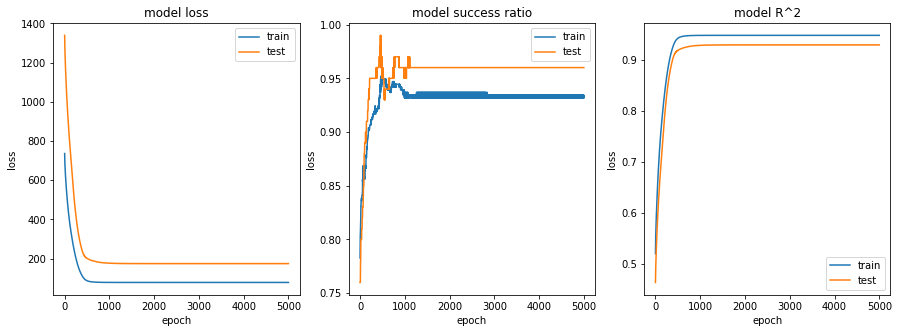

In [79]:
plt.figure(figsize=(15, 5)) 
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(132)
plt.plot(history.history['success_ratio'])
plt.plot(history.history['val_success_ratio']) 
plt.title('model success ratio') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(133)
plt.plot(history.history['r_coeff'])
plt.plot(history.history['val_r_coeff']) 
plt.title('model R^2') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

In [80]:
# make predictions
keras_in_sample = model.predict(train_X)
keras_out_sample = model.predict(test_X)

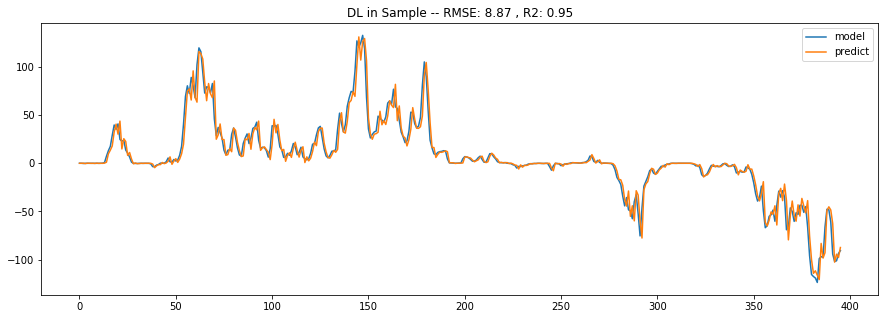

In [81]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(keras_in_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(train_Y, keras_in_sample))
r2 = r2_score(train_Y, keras_in_sample)
plt.title('DL in Sample -- RMSE: %.2f , R2: %.2f' % (rmse, r2))
plt.legend(loc=0)
plt.show()

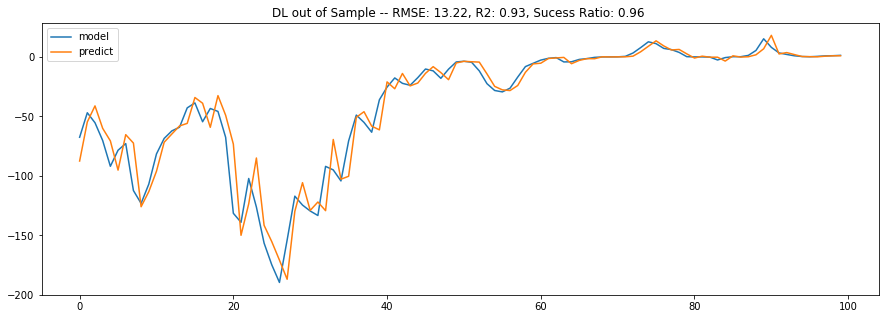

In [82]:
plt.figure(figsize=(15, 5))
plt.plot(test_Y, label='model')
plt.plot(keras_out_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(test_Y, keras_out_sample))
r2 = r2_score(test_Y, keras_out_sample)
# Success ratio
sr = np.mean(np.sign(keras_out_sample)==np.sign(test_Y))
plt.title('DL out of Sample -- RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (rmse, r2, sr))
plt.legend(loc=0)
plt.show()